# Whole image quality control metric evaluation

In this notebook, we will use the outputted QC metrics to start working on developing thresholds using z-score to flag and skip images during CellProfiler illumination correction.
We merge all 4 plates together to find the most optimal thresholds across all of them.
Since the A647 and GOLD channels tend to be less bright and have less objects within the image, we will not use them for thresholding and only use the DAPI channel in this notebook.

**Blur metric to detect out of focus images** -> PowerLogLogSlope

**Saturation metric to detect large smudges** -> PercentMaximal

## Import libraries

In [1]:
import pathlib
import pandas as pd

from scipy.stats import zscore
import matplotlib.pyplot as plt
import seaborn as sns

## Set paths and load in data frame

In [2]:
# Set the threshold for identifying outliers with z-scoring for all metrics (# of standard deviations away from mean)
threshold_z = 2

# Directory for figures to be outputted
figure_dir = pathlib.Path("./qc_figures")
figure_dir.mkdir(exist_ok=True)

# Directory containing the QC results
qc_results_dir = pathlib.Path("./qc_results")

# List to store DataFrames
dfs = []

# Iterate over each folder in qc_results and read the Image.csv file
for folder in qc_results_dir.iterdir():
    image_csv_path = folder / "Image.csv"
    if image_csv_path.exists():
        df = pd.read_csv(image_csv_path)
        dfs.append(df)

# Concatenate all DataFrames into a single DataFrame
qc_df = pd.concat(dfs, ignore_index=True)

print(qc_df.shape)
qc_df.head()

(1404, 73)


,Channel_A647,Channel_DAPI,Channel_GOLD,ExecutionTime_01Images,ExecutionTime_02Metadata,ExecutionTime_03NamesAndTypes,ExecutionTime_04Groups,ExecutionTime_05MeasureImageQuality,FileName_A647,FileName_DAPI,...,Scaling_GOLD,Series_A647,Series_DAPI,Series_GOLD,URL_A647,URL_DAPI,URL_GOLD,Width_A647,Width_DAPI,Width_GOLD
0,-1,-1,-1,0.0,0.0,2.06,0.0,6.08,slide3_A1_M14_CH1_Z09.tiff,slide3_A1_M14_CH0_Z09.tiff,...,65535,0,0,0,file:/media/18tbdrive/Github_Repositories/nucl...,file:/media/18tbdrive/Github_Repositories/nucl...,file:/media/18tbdrive/Github_Repositories/nucl...,2304,2304,2304
1,-1,-1,-1,0.0,0.0,1.46,0.0,6.54,slide3_A1_M15_CH1_Z09.tiff,slide3_A1_M15_CH0_Z09.tiff,...,65535,0,0,0,file:/media/18tbdrive/Github_Repositories/nucl...,file:/media/18tbdrive/Github_Repositories/nucl...,file:/media/18tbdrive/Github_Repositories/nucl...,2304,2304,2304
2,-1,-1,-1,0.0,0.0,0.79,0.0,6.17,slide3_A1_M16_CH1_Z09.tiff,slide3_A1_M16_CH0_Z09.tiff,...,65535,0,0,0,file:/media/18tbdrive/Github_Repositories/nucl...,file:/media/18tbdrive/Github_Repositories/nucl...,file:/media/18tbdrive/Github_Repositories/nucl...,2304,2304,2304
3,-1,-1,-1,0.0,0.0,0.78,0.0,6.07,slide3_A1_M17_CH1_Z09.tiff,slide3_A1_M17_CH0_Z09.tiff,...,65535,0,0,0,file:/media/18tbdrive/Github_Repositories/nucl...,file:/media/18tbdrive/Github_Repositories/nucl...,file:/media/18tbdrive/Github_Repositories/nucl...,2304,2304,2304
4,-1,-1,-1,0.0,0.0,0.58,0.0,5.96,slide3_A1_M18_CH1_Z09.tiff,slide3_A1_M18_CH0_Z09.tiff,...,65535,0,0,0,file:/media/18tbdrive/Github_Repositories/nucl...,file:/media/18tbdrive/Github_Repositories/nucl...,file:/media/18tbdrive/Github_Repositories/nucl...,2304,2304,2304


## Create concat dataframe combining blur and saturation metrics from all channels

In [3]:
# Define the channel of interest
channel = "DAPI"

# Create a DataFrame for the channel with all Metadata columns (excluding Series and Frame)
df = (
    qc_df.filter(like="Metadata_")
    .drop(columns=[
        "Metadata_Series",
        "Metadata_Frame",
        "Metadata_Channel",
        "Metadata_FileLocation",
    ])
    .copy()
)

# Add ImageQuality columns for the channel
df[f"ImageQuality_PowerLogLogSlope"] = qc_df[f"ImageQuality_PowerLogLogSlope_{channel}"]
df[f"ImageQuality_PercentMaximal"] = qc_df[f"ImageQuality_PercentMaximal_{channel}"]

# Add "Channel" column
df["Channel"] = channel

print(df.shape)
df.head()

(1404, 6)


,Metadata_Plate,Metadata_Site,Metadata_Well,ImageQuality_PowerLogLogSlope,ImageQuality_PercentMaximal,Channel
0,slide3,M14,A1,-2.311039,0.000019,DAPI
1,slide3,M15,A1,-2.394690,0.000019,DAPI
2,slide3,M16,A1,-2.278698,0.000019,DAPI
3,slide3,M17,A1,-2.375409,0.000019,DAPI
4,slide3,M18,A1,-2.423554,0.000019,DAPI


## Visualize blur metric

We use PowerLogLogSlope as the metric for blur (most recommended). We are looking for the most negative or blurry images as we have found in this dataset that anything very positive is still a good quality image.

/home/jenna/mambaforge/envs/python_nuclear_speckle_env/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/jenna/mambaforge/envs/python_nuclear_speckle_env/lib/python3.9/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/jenna/mambaforge/envs/python_nuclear_speckle_env/lib/python3.9/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_gr

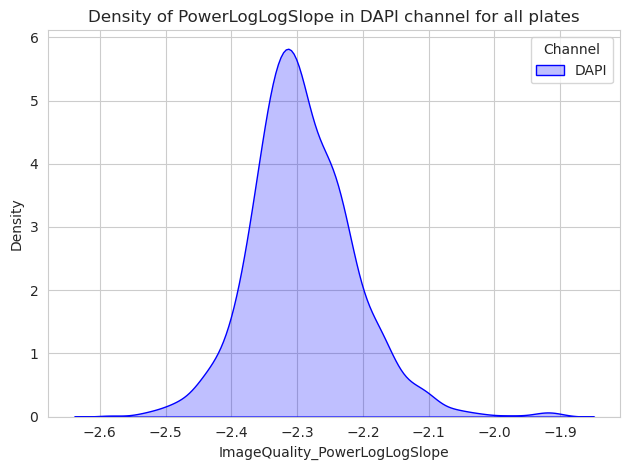

In [4]:
sns.set_style('whitegrid')
sns.kdeplot(data=df, x='ImageQuality_PowerLogLogSlope', hue='Channel', palette=['b'],fill=True, common_norm=False)
plt.title(f'Density of PowerLogLogSlope in DAPI channel for all plates')
plt.xlabel('ImageQuality_PowerLogLogSlope')
plt.ylabel('Density')

plt.tight_layout()
plt.savefig(pathlib.Path(f"{figure_dir}/all_plates_channels_blur_density.png"), dpi=500)
plt.show()

In [5]:
summary_statistics = df["ImageQuality_PowerLogLogSlope"].describe()
print(summary_statistics)

count    1404.000000
mean       -2.291897
std         0.079141
min        -2.583345
25%        -2.341490
50%        -2.298823
75%        -2.246238
max        -1.904406
Name: ImageQuality_PowerLogLogSlope, dtype: float64


In [6]:
# Calculate Z-scores for the column
z_scores = zscore(df['ImageQuality_PowerLogLogSlope'])

# Identify outlier rows based on Z-scores below the mean since we are looking for the blurriest images (more negative)
blur_outliers = df[z_scores < -3]

print(blur_outliers.shape)
print(blur_outliers['Channel'].value_counts())
blur_outliers.sort_values(by='ImageQuality_PowerLogLogSlope', ascending=False)


(3, 6)
Channel
DAPI    3
Name: count, dtype: int64


,Metadata_Plate,Metadata_Site,Metadata_Well,ImageQuality_PowerLogLogSlope,ImageQuality_PercentMaximal,Channel
768,slide1,M60,A3,-2.530333,0.000019,DAPI
659,slide2,M57,B4,-2.534797,0.000019,DAPI
615,slide2,M17,B4,-2.583345,0.402079,DAPI


In [7]:
# Calculate the mean and standard deviation
mean_value = df["ImageQuality_PowerLogLogSlope"].mean()
std_dev = df["ImageQuality_PowerLogLogSlope"].std()

# Calculate the threshold values
threshold_value_below_mean = mean_value + -3 * std_dev

# Print the calculated threshold values
print("Threshold for outliers below the mean:", threshold_value_below_mean)

Threshold for outliers below the mean: -2.52931951159482


## Saturation metric

We use Percent Maxmimal as the saturation metric. We are looking for images with a large, bright smudge which tends to only occur in the DAPI channel.

In [8]:
summary_statistics = df["ImageQuality_PercentMaximal"].describe()
print(summary_statistics)

count    1404.000000
mean        0.000344
std         0.010826
min         0.000019
25%         0.000019
50%         0.000019
75%         0.000019
max         0.402079
Name: ImageQuality_PercentMaximal, dtype: float64


/home/jenna/mambaforge/envs/python_nuclear_speckle_env/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


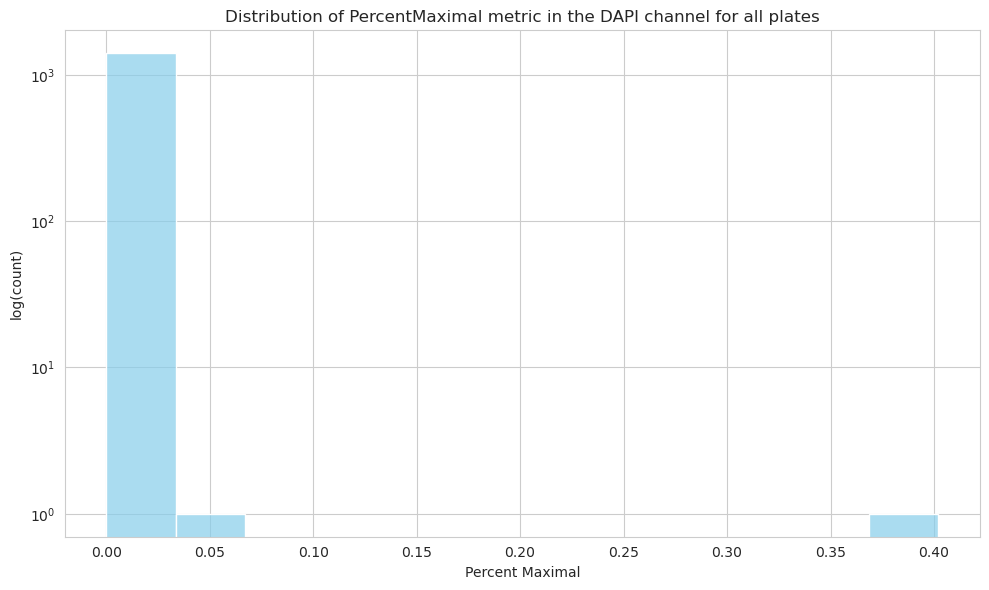

In [9]:
# Create a histogram plot
plt.figure(figsize=(10, 6))
sns.histplot(df['ImageQuality_PercentMaximal'], color='skyblue', alpha=0.7)

# Set labels and title
plt.ylabel('log(count)')
plt.xlabel('Percent Maximal')
plt.title('Distribution of PercentMaximal metric in the DAPI channel for all plates')
plt.yscale('log')  # Set y-axis to logarithmic scale
plt.tight_layout()

plt.savefig(pathlib.Path(f"{figure_dir}/all_plates_percent_maximal.png"), dpi=500)

# Show the plot
plt.show()


In [10]:
# Calculate Z-scores for the column
z_scores = zscore(df['ImageQuality_PercentMaximal'])

# Identify outlier rows based on Z-scores greater than as to identify whole images with abnormally high saturated pixels
sat_outliers = df[z_scores > 2]

print(sat_outliers.shape)
print(sat_outliers['Channel'].value_counts())
sat_outliers.sort_values(by='ImageQuality_PercentMaximal', ascending=True).head()

(2, 6)
Channel
DAPI    2
Name: count, dtype: int64


,Metadata_Plate,Metadata_Site,Metadata_Well,ImageQuality_PowerLogLogSlope,ImageQuality_PercentMaximal,Channel
616,slide2,M18,B4,-2.196128,0.054272,DAPI
615,slide2,M17,B4,-2.583345,0.402079,DAPI


In [11]:
# Calculate the mean and standard deviation
mean_value = df["ImageQuality_PercentMaximal"].mean()
std_dev = df["ImageQuality_PercentMaximal"].std()

# Calculate the threshold values
threshold_value_above_mean = mean_value + 2 * std_dev

# Print the calculated threshold values
print("Threshold for outliers above the mean:", threshold_value_above_mean)

Threshold for outliers above the mean: 0.021997234660547066
